In [1]:
import gzip
import pandas as pd
from collections import defaultdict

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

train_df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

In [2]:
train_df.shape

(200000, 12)

In [3]:
import itertools

train_df['categories'] = train_df.categories.apply(lambda x: list(itertools.chain(*x))).apply(lambda x: [each.split(',') for each in x]).apply(lambda x: list(set(itertools.chain(*x))))
test_df['categories'] = test_df.categories.apply(lambda x: list(itertools.chain(*x))).apply(lambda x: [each.split(',') for each in x]).apply(lambda x: list(set(itertools.chain(*x))))

In [4]:
categories_fit = train_df.categories.to_list()
test_categories_fit = test_df.categories.to_list()

In [5]:
from sklearn import preprocessing
lb = preprocessing.MultiLabelBinarizer()

lb.fit(categories_fit)
train_cats = pd.DataFrame(lb.transform(categories_fit),columns = lb.classes_)
test_cats = pd.DataFrame(lb.transform(test_categories_fit),columns = lb.classes_)

In [6]:
train_df.drop('categories',axis = 1,inplace = True)
test_df.drop('categories',axis = 1, inplace = True)

In [7]:
train = pd.concat([train_df,train_cats],axis = 1)
test = pd.concat([test_df,test_cats],axis = 1)

In [8]:
train.head(2)

,categoryID,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,...,ZiGiny,adidas,adidas Originals,bebe,cobian,crocs,dollhouse,indigo by Clarks,nicole,pediped
0,0,I655355328,U745881038,3.0,"These are cute, but they are a little small. ...",R115160670,"05 20, 2014",Cute,1400544000,"{'outOf': 0, 'nHelpful': 0}",...,0,0,0,0,0,0,0,0,0,0
1,0,I241092314,U023577405,4.0,"I love the look of this bra, it is what I want...",R800651687,"02 7, 2013",Beautiful but size runs small,1360195200,"{'outOf': 0, 'nHelpful': 0}",...,0,0,0,0,0,0,0,0,0,0


In [9]:
helpfulNess_train = pd.DataFrame(train_df.helpful.apply(lambda x: [x['outOf'],x['nHelpful']]).to_list(),columns = ['outOf','nHelpful'])

helpfulNess_test = pd.DataFrame(test_df.helpful.apply(lambda x: [x['outOf']]).to_list(),columns = ['outOf'])

In [10]:
train = pd.concat([train,helpfulNess_train],axis = 1)
test = pd.concat([test,helpfulNess_test],axis = 1)

### Price analysis. Is it worth to keep this feature in our analysis? There does not seem to be too much variance in the prices

In [11]:
train.price.hist(bins=100)

In [12]:
train.drop(['helpful','reviewHash','reviewText','price'],axis = 1,inplace = True)
test.drop(['helpful','reviewHash','reviewText','price'],axis = 1,inplace = True)

In [13]:
month = train.reviewTime.apply(lambda x: [each.replace(',','') for each in str(x).split(' ')]).apply(lambda x:x[0])
day = train.reviewTime.apply(lambda x: [each.replace(',','') for each in str(x).split(' ')]).apply(lambda x:x[1])
year = train.reviewTime.apply(lambda x: [each.replace(',','') for each in str(x).split(' ')]).apply(lambda x:x[2])

month_test = test.reviewTime.apply(lambda x: [each.replace(',','') for each in str(x).split(' ')]).apply(lambda x:x[0])
day_test = test.reviewTime.apply(lambda x: [each.replace(',','') for each in str(x).split(' ')]).apply(lambda x:x[1])
year_test = test.reviewTime.apply(lambda x: [each.replace(',','') for each in str(x).split(' ')]).apply(lambda x:x[2])

In [14]:
train.drop(['reviewTime'],axis = 1,inplace = True)
test.drop(['reviewTime'],axis = 1,inplace = True)
train.drop(['unixReviewTime'],axis = 1,inplace = True)
test.drop(['unixReviewTime'],axis = 1,inplace = True)

train['day'] = day
train['month'] = month
train['year'] = year

test['day'] = day_test
test['month'] = month_test
test['year'] = year_test

In [15]:
train.drop(['summary'],axis = 1,inplace = True)
test.drop(['summary'], axis = 1,inplace = True)

In [16]:
#train['price'] = train.price.fillna(0)
#test['price'] = test.price.fillna(0)

### Problem of being sparse. How can we reduce that dimensionality?
### How do we select important features from this ?

In [17]:
train.head(2)

,categoryID,itemID,reviewerID,rating,Card Cases & Money Organizers,Chemises & Negligees,Costumes & More,Crafts & Sewing,Diaper Covers & Underwear,Five & Seven Stone Jewelry,...,crocs,dollhouse,indigo by Clarks,nicole,pediped,outOf,nHelpful,day,month,year
0,0,I655355328,U745881038,3.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,20,05,2014
1,0,I241092314,U023577405,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,02,2013


In [18]:
from sklearn.preprocessing import LabelEncoder

l_item = LabelEncoder()
l_item.fit(train.itemID)

LabelEncoder()

In [19]:
train['itemID'] = l_item.transform(train.itemID)

In [20]:
test['itemID'] = l_item.transform(test.itemID)

### How can we account for the fact that the reviewer might be new? 

In [21]:
l_review = LabelEncoder()
l_review.fit(train.reviewerID.append(test.reviewerID))

train['reviewerID'] = l_review.transform(train.reviewerID)
test['reviewerID'] = l_review.transform(test.reviewerID)

In [22]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(train.shape[1]):
    colname = train.columns[i]
    scalers[colname] = StandardScaler()
    train[colname] = scalers[colname].fit_transform(train[colname].to_numpy().reshape(-1,1))

In [23]:
for i in range(test.shape[1]):
    colname = test.columns[i]
    test[colname] = scalers[colname].transform(test[colname].to_numpy().reshape(-1,1)) 

In [24]:
train.head(10)

,categoryID,itemID,reviewerID,rating,Card Cases & Money Organizers,Chemises & Negligees,Costumes & More,Crafts & Sewing,Diaper Covers & Underwear,Five & Seven Stone Jewelry,...,crocs,dollhouse,indigo by Clarks,nicole,pediped,outOf,nHelpful,day,month,year
0,-0.525734,0.549252,0.855597,-1.113633,-0.109532,-0.031797,2.026411,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,0.509141,-0.292471,0.920535
1,-0.525734,-0.890609,-1.641091,-0.210875,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,-0.983304,-1.120672,-0.102776
2,-0.525734,-0.308782,-0.185840,-1.113633,-0.109532,-0.031797,2.026411,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,0.109534,0.150873,-0.294483,-0.292471,0.920535
3,-0.525734,0.950422,0.542445,-0.210875,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,1.083158,-0.292471,0.920535
4,-0.525734,1.464373,-1.376117,0.691883,-0.109532,-0.031797,2.026411,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.049014,-0.019673,1.657175,0.259663,-0.102776
5,-0.525734,-1.376712,-0.046935,-0.210875,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.049014,-0.019673,-0.753697,0.535730,-0.102776
6,-0.525734,1.223323,0.132763,0.691883,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,0.509141,0.811797,-0.102776
7,-0.525734,0.724514,-1.046525,0.691883,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,-1.327715,-0.568538,0.920535
8,-0.525734,1.362557,0.217073,-0.210875,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,-0.294483,-1.120672,0.920535
9,-0.525734,-0.987551,1.156617,0.691883,-0.109532,-0.031797,-0.493483,-0.010001,-0.019879,-0.015654,...,-0.118986,-0.010247,-0.004472,-0.003873,-0.009487,-0.207563,-0.190219,1.312765,-1.120672,-0.102776


### Tried a couple of machine learning models , but RandomForestRegressor seems to work the best. Random Forest works best even without standardization. DecisionTree seems to give binary results. Nothing in between. MAE in RandomForests takes a lot of time to converge.

### Feature extraction

#### Adding Tokenizer to the model. Also considering length of the review as feature.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'))
train_text = vectorizer.fit_transform(train_df.reviewText)

In [26]:
test_text = vectorizer.transform(test_df.reviewText)

#### Adding Bag of Words model for summary.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer


count_vectorizer = TfidfVectorizer(stop_words= stopwords.words('english'))
train_summary = count_vectorizer.fit_transform(train_df.summary)

In [28]:
test_summary = count_vectorizer.transform(test_df.summary)

In [29]:
import scipy

train_csr = scipy.sparse.csr_matrix(train.loc[:,train.columns != 'nHelpful'].apply(lambda x: x.astype('float64')).values)
test_csr = scipy.sparse.csr_matrix(test.apply(lambda x: x.astype('float64')).values)

### Linear model training takes very less time  to train but gets a mae of about 2.5

In [30]:
def make_predictions(preds,message):
    predictions = pd.DataFrame([l_review.inverse_transform(test.reviewerID),l_item.inverse_transform(test.itemID),test.outOf.to_numpy(),preds]).T
    predictions[0] = predictions[0] + '-' + predictions[1] + '-'
    predictions[0] = predictions[0] + predictions[2].apply(lambda x: str(x).strip())
    predictions.drop([1,2],axis = 1 ,inplace = True)
    predictions.rename(columns = {0:'userID-itemID-outOf',3:'prediction'},inplace = True)
    predictions.to_csv('predictions_first.csv',sep= ',',index = False)
    !kaggle competitions submit -c dse220 -f predictions_first.csv -m 'Pure random Forest , no dimensionality reduction only removal of features'

### Trying clustering on categories columns. Reducing dimensionality of  the data. Branch only if you want to reduce dimensionality in some or the other way

In [175]:
cols = train.columns[5:1055]

In [176]:
from sklearn.cluster import MiniBatchKMeans,KMeans

n = [2,3,10,50,100,200,500,1000]

means = []

for k in n:
    print("Working on k value %d"%k)
    means.append(MiniBatchKMeans(n_clusters=k,init = 'k-means++',max_iter = 1).fit(train[cols]))

Working on k value 2
Working on k value 3
Working on k value 10
Working on k value 50
Working on k value 100
Working on k value 200
Working on k value 500


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Working on k value 1000


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


In [177]:
rmses = []

for mean in means:
    rmses.append(mean.score(test[cols]))

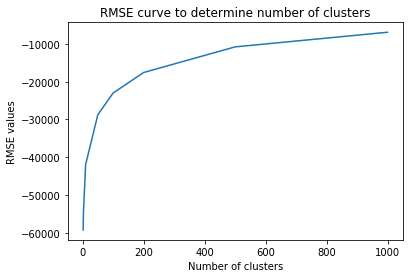

In [178]:
import matplotlib.pyplot as plt

plt.plot(n,rmses)
plt.title('RMSE curve to determine number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('RMSE values')
plt.show()

### It seems like after 500 , the other dimensions add complexity for the model. Let's still fine tune between 200 and 500

In [179]:
n = [200,250,300,350,400,450,500]

means = []

for k in n:
    print("Working on k value %d"%k)
    means.append(MiniBatchKMeans(n_clusters=k,init = 'k-means++',max_iter = 1).fit(train[cols]))

Working on k value 200
Working on k value 250
Working on k value 300
Working on k value 350


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=350. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=350. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=350. Setting it to 3*k
  init_size=init_size)


Working on k value 400


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Working on k value 450


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)


Working on k value 500


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


In [180]:
rmses = []

for mean in means:
    rmses.append(mean.score(test[cols]))

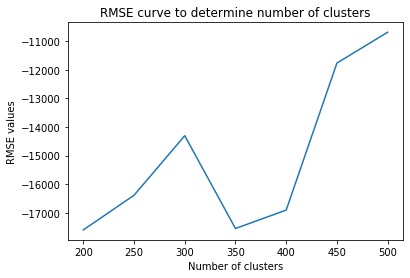

In [181]:
import matplotlib.pyplot as plt

plt.plot(n,rmses)
plt.title('RMSE curve to determine number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('RMSE values')
plt.show()

### RMSE still increasing. Thus lets assume there are 500 categories and cluster data to these 500 values.

In [185]:
mean500 = means[-1]

In [186]:
train_transformed = train[train.columns[0:5]]
train_transformed['cluster'] = mean500.predict(train[cols])
train = pd.concat([train_transformed,train[train.columns[1055:]]],axis = 1)

test_transformed = test[test.columns[0:5]]
test_transformed['cluster'] = mean500.predict(test[cols])
test = pd.concat([test_transformed,test[test.columns[1055:]]],axis = 1)

KeyError: "None of [Index([' Card Cases & Money Organizers', ' Chemises & Negligees',\n       ' Costumes & More', ' Crafts & Sewing', ' Diaper Covers & Underwear',\n       ' Five & Seven Stone Jewelry', ' Holders & Racks', ' Mittens & Liners',\n       ' Rompers & Overalls', ' Safety & Work Gloves',\n       ...\n       'ZiGiny', 'adidas', 'adidas Originals', 'bebe', 'cobian', 'crocs',\n       'dollhouse', 'indigo by Clarks', 'nicole', 'pediped'],\n      dtype='object', length=1050)] are in the [columns]"

In [31]:
import scipy
from scipy.sparse import hstack

train_csr = scipy.sparse.csr_matrix(train.loc[:,train.columns != 'nHelpful'].apply(lambda x: x.astype('float64')).values)
test_csr = scipy.sparse.csr_matrix(test.apply(lambda x: x.astype('float64')).values)


train_data = hstack((train_csr,train_text,train_summary))
test_data = hstack((test_csr,test_text,test_summary))

In [32]:
### Skip dimensionality reduction and try whats happening

In [33]:
import scipy
from scipy.sparse import hstack

train_data = hstack((train_csr,train_text,train_summary))
test_data = hstack((test_csr,test_text,test_summary))

### SVR takes a lot of time to train

In [34]:
from sklearn.model_selection import train_test_split

train_csr_new,val_new, train_y , val_y = train_test_split(train_data,train['nHelpful'],test_size = 0.2,random_state = 42)

In [35]:
from sklearn.svm import LinearSVR

svr = LinearSVR(verbose = 1, C = 1)
svr.fit(train_csr_new,train_y)

[LibLinear]

/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=1)

In [42]:
from sklearn.metrics import mean_absolute_error
#svr.predict(val_new

mean_absolute_error(scalers['nHelpful'].inverse_transform(val_y),scalers['nHelpful'].inverse_transform(svr.predict(val_new)))

0.37086442887462445

In [196]:
# from sklearn.decomposition import  TruncatedSVD

# svd = TruncatedSVD(n_components=20)
# svd.fit(train_csr_new)

# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(max_features=None,n_estimators=256,verbose= 1)
# rf.fit(svd.transform(train_csr_new),train_y)

# from sklearn.metrics import mean_absolute_error

# mean_absolute_error(val_y,smooth_predictions(rf.predict(svd.transform(val_new))))

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
             random_state=None, tol=0.0)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lm = LinearRegression(normalize = True,n_jobs = -1)
lm.fit(train_csr_new,train_y)
mean_absolute_error(val_y,lm.predict(val_new))

0.07329296424956615

In [44]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(scalers['nHelpful'].inverse_transform(val_y),scalers['nHelpful'].inverse_transform(lm.predict(val_new)))
#mean_absolute_error(val_y,smooth_predictions(lm.predict(val_new)))

0.4297545206997986

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=None,n_estimators=10,verbose= 1,n_jobs = -1)
rf.fit(train_csr_new,train_y)

### Accuracy of the linear regressor improves with normalization.

array([ 0., -0.,  0., ...,  0.,  4.,  3.])

In [40]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(val_y,svr.predict(val_new))

0.06324948783012618

In [238]:
preds = rf.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 256 out of 256 | elapsed:    0.3s finished


In [239]:
preds

array([1.33984375, 0.        , 0.85546875, ..., 0.        , 0.        ,
       1.23828125])

In [38]:
def smooth_predictions(preds):
    import numpy as np
    for i in range(0,preds.shape[0]):
        x = preds[i]
        if x % 1 > 0.5:
            preds[i] = np.ceil(x) 
        else: 
            preds[i] = np.floor(x)
    return preds

In [245]:
make_predictions(preds,'Random Forest regressor with 256 estimators, took 3 hours to train. No Dimensionality reduction')

100%|████████████████████████████████████████| 409k/409k [00:08<00:00, 50.9kB/s]
Successfully submitted to DSE 220 - Project

### Tried max feature reduction to reduce the dimensionality of the text data too. This resulted in an increase in mae value.